# Module 2: Insurance Claims & Premium Modeling (GLM Results)

This notebook presents the results of three Generalized Linear Models analyzing how climate disaster exposure drives insurance outcomes:

1. **Gamma GLM** — Models claim severity (positive claims only)
2. **Tweedie GLM** — Models claim severity including zero-claim counties
3. **Logistic Regression** — Predicts which counties will see claims surges (>50% YoY increase)

**Data:** County-year panel (2004-2024) combining FEMA disasters, NFIP flood insurance claims, Census demographics, and FRED macro indicators.

In [1]:
import sys
sys.path.insert(0, "..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from src.utils.config import MODELS_DIR, REPORTS_FIGURES, DATA_PROCESSED

REPORTS_FIGURES.mkdir(parents=True, exist_ok=True)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["figure.dpi"] = 100

print("Setup complete.")

Setup complete.


## 1. Load Model Results

In [2]:
# Load all saved results
gamma_coefs = pd.read_csv(MODELS_DIR / "gamma_glm_coefficients.csv")
tweedie_coefs = pd.read_csv(MODELS_DIR / "tweedie_glm_coefficients.csv")
logistic_coefs = pd.read_csv(MODELS_DIR / "logistic_coefficients.csv")
glm_metrics = pd.read_csv(MODELS_DIR / "glm_comparison_metrics.csv")
logistic_metrics = pd.read_csv(MODELS_DIR / "logistic_metrics.csv")
tweedie_search = pd.read_csv(MODELS_DIR / "tweedie_power_search.csv")
gamma_diag = pd.read_csv(MODELS_DIR / "gamma_glm_diagnostics.csv")
roc_data = pd.read_csv(MODELS_DIR / "logistic_roc_curve.csv")
pred_data = pd.read_csv(MODELS_DIR / "logistic_predictions.csv")
panel = pd.read_csv(DATA_PROCESSED / "county_year_panel_glm_ready.csv", dtype={"county_fips": str})

print("Gamma GLM coefficients:", len(gamma_coefs))
print("Logistic coefficients:", len(logistic_coefs))
print("Panel dataset:", panel.shape)

# Display model comparison
print("\n=== Severity Model Comparison ===")
display(glm_metrics[["model", "aic", "test_rmse", "test_mae", "test_r2"]].round(2))

print("\n=== Logistic Regression Metrics ===")
display(logistic_metrics.round(4))

Gamma GLM coefficients: 25
Logistic coefficients: 25
Panel dataset: (25415, 65)

=== Severity Model Comparison ===


,model,aic,test_rmse,test_mae,test_r2
0,Gamma GLM,213942.25,39175.90,29560.26,-0.13
1,Tweedie (p=1.4),825146.78,30287.08,12378.22,-0.20



=== Logistic Regression Metrics ===


,auc_roc,avg_precision,optimal_threshold,cv_auc_mean,cv_auc_std
0,0.6869,0.4815,0.8462,0.7283,0.0154


## 2. Gamma GLM: Claim Severity Drivers

The Gamma GLM models **how much** insurance claims cost, conditional on a claim being filed. The log link means coefficients have a **multiplicative interpretation**: exp(β) tells you how much a 1-unit increase in a feature multiplies expected claim severity.

In [3]:
# Gamma GLM coefficient table
gamma_display = gamma_coefs[gamma_coefs["feature"] != "intercept"].copy()
gamma_display["pct_effect"] = (gamma_display["exp_coef"] - 1) * 100
gamma_display = gamma_display.sort_values("exp_coef", ascending=False)

print("Gamma GLM: Multiplicative Effects on Claim Severity")
print("="*70)
print(f"{'Feature':<30} {'exp(β)':>8} {'% Effect':>10} {'p-value':>10} {'Sig':>5}")
print("-"*70)
for _, row in gamma_display.iterrows():
    sig = "***" if row["p_value"] < 0.001 else "**" if row["p_value"] < 0.01 else "*" if row["p_value"] < 0.05 else ""
    print(f"{row['feature']:<30} {row['exp_coef']:>8.4f} {row['pct_effect']:>+9.1f}% {row['p_value']:>10.4f} {sig:>5}")

Gamma GLM: Multiplicative Effects on Claim Severity
Feature                          exp(β)   % Effect    p-value   Sig
----------------------------------------------------------------------
fema_region_6                    2.5383    +153.8%     0.0000   ***
fema_region_9                    2.5138    +151.4%     0.0000   ***
CPIAUCSL                         2.2570    +125.7%     0.0000   ***
fema_region_7                    2.1845    +118.4%     0.0000   ***
fema_region_4                    2.1466    +114.7%     0.0000   ***
fema_region_10                   2.1226    +112.3%     0.0000   ***
fema_region_2                    2.0419    +104.2%     0.0000   ***
fema_region_3                    1.8016     +80.2%     0.0000   ***
fema_region_5                    1.7285     +72.9%     0.0000   ***
fema_region_1                    1.5771     +57.7%     0.0000   ***
fema_region_8                    1.5764     +57.6%     0.0000   ***
flood_count                      1.2859     +28.6%     0.0000

## 3. Forest Plot: Exponentiated Coefficients (Gamma GLM)

Each point shows the multiplicative effect of a feature on expected claim severity. Values > 1.0 mean the feature **increases** claims; values < 1.0 mean it **decreases** claims. Error bars show 95% confidence intervals.

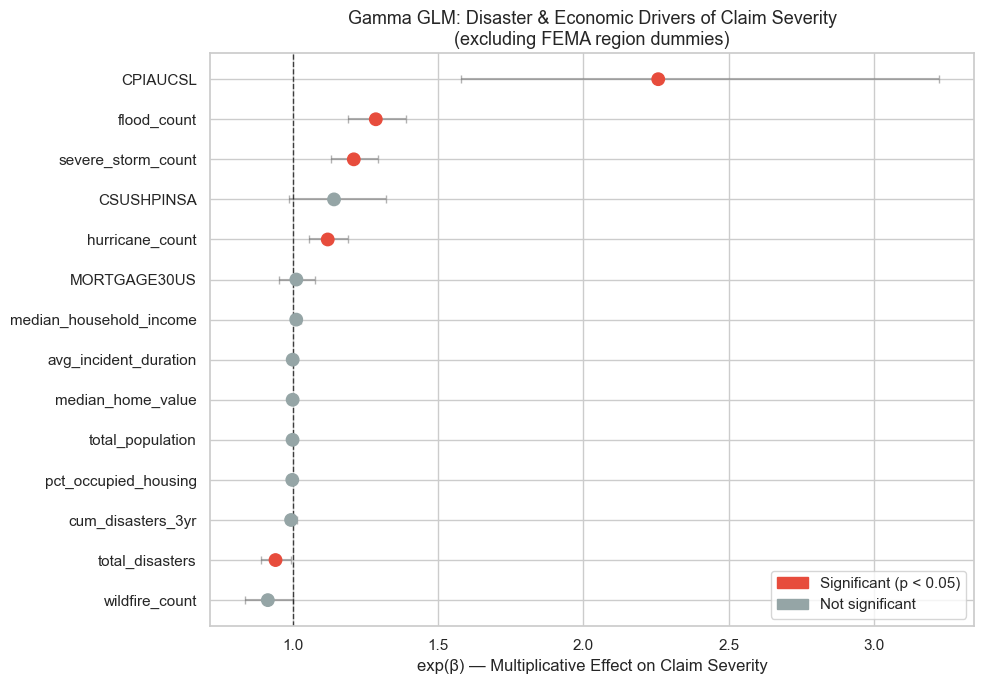

In [4]:
# Forest plot of Gamma GLM exponentiated coefficients
plot_data = gamma_coefs[
    (gamma_coefs["feature"] != "intercept") & 
    (~gamma_coefs["feature"].str.startswith("fema_region"))
].copy()
plot_data = plot_data.sort_values("exp_coef")

fig, ax = plt.subplots(figsize=(10, 7))

colors = ["#e74c3c" if p < 0.05 else "#95a5a6" for p in plot_data["p_value"]]

ax.errorbar(
    plot_data["exp_coef"],
    range(len(plot_data)),
    xerr=[plot_data["exp_coef"] - plot_data["ci_lower"],
          plot_data["ci_upper"] - plot_data["exp_coef"]],
    fmt="none", ecolor="gray", capsize=3, alpha=0.6,
)
ax.scatter(plot_data["exp_coef"], range(len(plot_data)), c=colors, s=80, zorder=3)
ax.axvline(x=1.0, color="black", linestyle="--", linewidth=1, alpha=0.7)

ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data["feature"])
ax.set_xlabel("exp(β) — Multiplicative Effect on Claim Severity")
ax.set_title("Gamma GLM: Disaster & Economic Drivers of Claim Severity\n(excluding FEMA region dummies)", fontsize=13)

# Legend
sig_patch = mpatches.Patch(color="#e74c3c", label="Significant (p < 0.05)")
ns_patch = mpatches.Patch(color="#95a5a6", label="Not significant")
ax.legend(handles=[sig_patch, ns_patch], loc="lower right")

plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "gamma_forest_plot.png", bbox_inches="tight", dpi=150)
plt.show()

## 4. FEMA Region Effects

Regional differences in claim severity, relative to the baseline (counties with unassigned FEMA region).

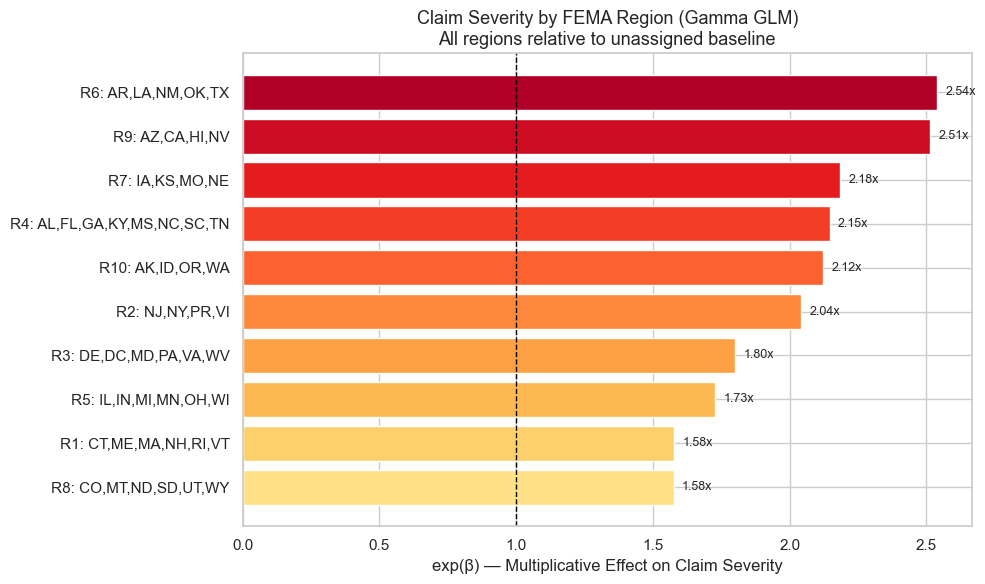

In [5]:
# FEMA Region effects
region_data = gamma_coefs[gamma_coefs["feature"].str.startswith("fema_region")].copy()
region_data["region"] = region_data["feature"].str.extract(r"(\d+)").astype(int)
region_data = region_data.sort_values("exp_coef", ascending=True)

region_labels = {
    1: "R1: CT,ME,MA,NH,RI,VT",
    2: "R2: NJ,NY,PR,VI",
    3: "R3: DE,DC,MD,PA,VA,WV",
    4: "R4: AL,FL,GA,KY,MS,NC,SC,TN",
    5: "R5: IL,IN,MI,MN,OH,WI",
    6: "R6: AR,LA,NM,OK,TX",
    7: "R7: IA,KS,MO,NE",
    8: "R8: CO,MT,ND,SD,UT,WY",
    9: "R9: AZ,CA,HI,NV",
    10: "R10: AK,ID,OR,WA",
}
region_data["label"] = region_data["region"].map(region_labels)

fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.YlOrRd(np.linspace(0.2, 0.9, len(region_data)))
ax.barh(region_data["label"], region_data["exp_coef"], color=colors)
ax.axvline(x=1.0, color="black", linestyle="--", linewidth=1)
ax.set_xlabel("exp(β) — Multiplicative Effect on Claim Severity")
ax.set_title("Claim Severity by FEMA Region (Gamma GLM)\nAll regions relative to unassigned baseline", fontsize=13)

for i, (_, row) in enumerate(region_data.iterrows()):
    ax.text(row["exp_coef"] + 0.03, i, f"{row['exp_coef']:.2f}x", va="center", fontsize=9)

plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "fema_region_effects.png", bbox_inches="tight", dpi=150)
plt.show()

## 5. Logistic Regression: Claims Surge Prediction

The logistic regression predicts which counties will see a **>50% year-over-year increase** in insurance claim count, using lagged features (year t-1 data predicts year t outcome).

**Odds Ratios:** OR > 1 means the feature increases surge probability; OR < 1 means it decreases it. Since features are standardized, ORs represent the effect of a 1 standard deviation change.

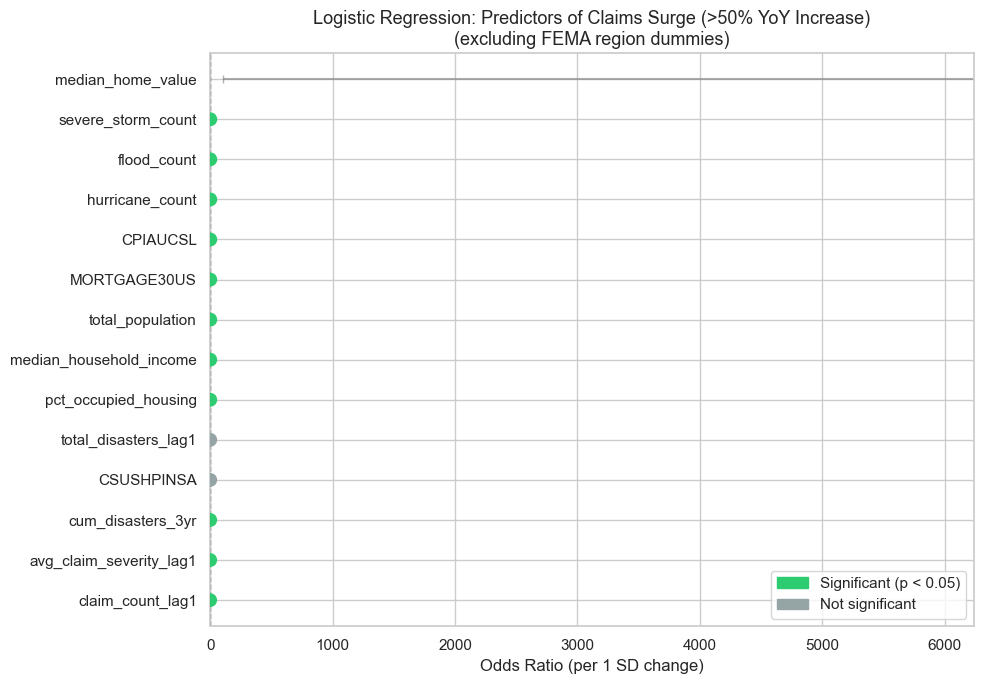

In [6]:
# Logistic regression odds ratios
lr_display = logistic_coefs[
    (logistic_coefs["feature"] != "intercept") &
    (~logistic_coefs["feature"].str.startswith("fema_region"))
].copy()
lr_display = lr_display.sort_values("exp_coef")

fig, ax = plt.subplots(figsize=(10, 7))

colors = ["#2ecc71" if p < 0.05 else "#95a5a6" for p in lr_display["p_value"]]

ax.errorbar(
    lr_display["exp_coef"],
    range(len(lr_display)),
    xerr=[lr_display["exp_coef"] - lr_display["ci_lower"],
          lr_display["ci_upper"] - lr_display["exp_coef"]],
    fmt="none", ecolor="gray", capsize=3, alpha=0.6,
)
ax.scatter(lr_display["exp_coef"], range(len(lr_display)), c=colors, s=80, zorder=3)
ax.axvline(x=1.0, color="black", linestyle="--", linewidth=1, alpha=0.7)

ax.set_yticks(range(len(lr_display)))
ax.set_yticklabels(lr_display["feature"])
ax.set_xlabel("Odds Ratio (per 1 SD change)")
ax.set_title("Logistic Regression: Predictors of Claims Surge (>50% YoY Increase)\n(excluding FEMA region dummies)", fontsize=13)

sig_patch = mpatches.Patch(color="#2ecc71", label="Significant (p < 0.05)")
ns_patch = mpatches.Patch(color="#95a5a6", label="Not significant")
ax.legend(handles=[sig_patch, ns_patch], loc="lower right")

# Clip x axis for readability (median_home_value has extreme OR)
ax.set_xlim(-0.5, max(5, lr_display["exp_coef"].quantile(0.95) * 1.3))

plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "logistic_odds_ratios.png", bbox_inches="tight", dpi=150)
plt.show()

## 6. ROC Curve & Precision-Recall Curve

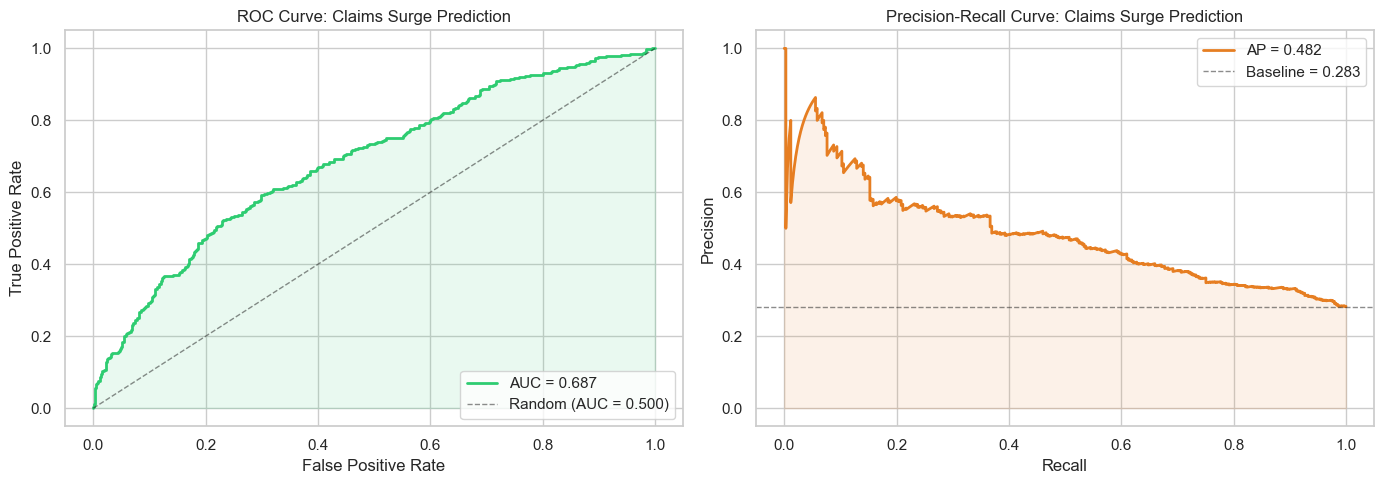

5-Fold CV AUC-ROC: 0.7283 ± 0.0154


In [7]:
from sklearn.metrics import precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
auc = logistic_metrics["auc_roc"].values[0]
axes[0].plot(roc_data["fpr"], roc_data["tpr"], color="#2ecc71", linewidth=2, label=f"AUC = {auc:.3f}")
axes[0].plot([0, 1], [0, 1], "k--", linewidth=1, alpha=0.5, label="Random (AUC = 0.500)")
axes[0].fill_between(roc_data["fpr"], roc_data["tpr"], alpha=0.1, color="#2ecc71")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve: Claims Surge Prediction")
axes[0].legend(loc="lower right")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(pred_data["y_test"], pred_data["y_prob"])
ap = average_precision_score(pred_data["y_test"], pred_data["y_prob"])
axes[1].plot(recall, precision, color="#e67e22", linewidth=2, label=f"AP = {ap:.3f}")
baseline = pred_data["y_test"].mean()
axes[1].axhline(y=baseline, color="k", linestyle="--", linewidth=1, alpha=0.5, label=f"Baseline = {baseline:.3f}")
axes[1].fill_between(recall, precision, alpha=0.1, color="#e67e22")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve: Claims Surge Prediction")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "roc_pr_curves.png", bbox_inches="tight", dpi=150)
plt.show()

print(f"5-Fold CV AUC-ROC: {logistic_metrics['cv_auc_mean'].values[0]:.4f} ± {logistic_metrics['cv_auc_std'].values[0]:.4f}")

## 7. Predicted Probability Distribution

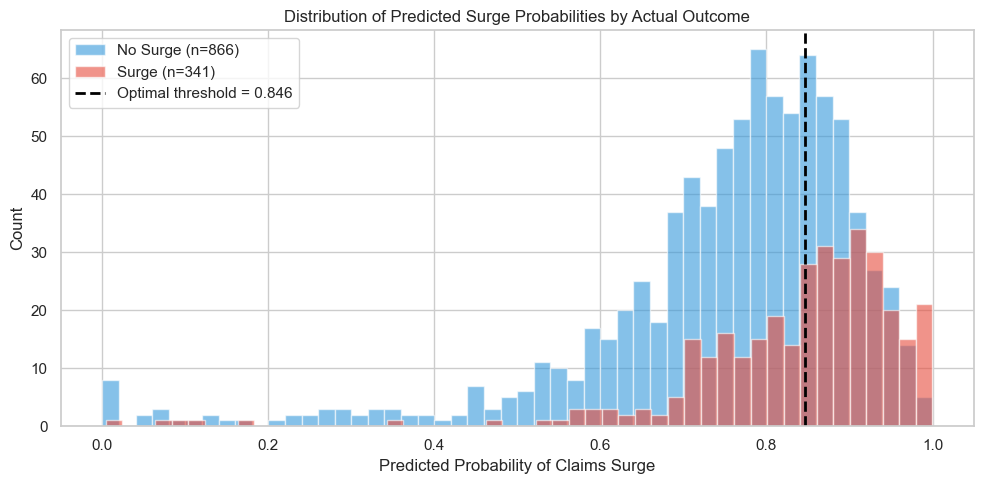

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

# Separate by actual outcome
no_surge = pred_data[pred_data["y_test"] == 0]["y_prob"]
surge = pred_data[pred_data["y_test"] == 1]["y_prob"]

ax.hist(no_surge, bins=50, alpha=0.6, color="#3498db", label=f"No Surge (n={len(no_surge)})")
ax.hist(surge, bins=50, alpha=0.6, color="#e74c3c", label=f"Surge (n={len(surge)})")

threshold = logistic_metrics["optimal_threshold"].values[0]
ax.axvline(x=threshold, color="black", linestyle="--", linewidth=2, label=f"Optimal threshold = {threshold:.3f}")

ax.set_xlabel("Predicted Probability of Claims Surge")
ax.set_ylabel("Count")
ax.set_title("Distribution of Predicted Surge Probabilities by Actual Outcome")
ax.legend()

plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "predicted_prob_distribution.png", bbox_inches="tight", dpi=150)
plt.show()

## 8. Gamma vs Tweedie Comparison

In [9]:
# Side-by-side model comparison
print("=" * 70)
print("SEVERITY MODEL COMPARISON: Gamma GLM vs Tweedie GLM")
print("=" * 70)

comparison = glm_metrics.set_index("model").T
comparison.index.name = "metric"
display(comparison.round(2))

# Tweedie power search
print("\nTweedie Power Parameter Grid Search:")
display(tweedie_search.round(1))

print("\nKey Differences:")
print("• Gamma GLM: Uses only positive claims (11K rows), better AIC")
print("• Tweedie GLM: Uses all county-years including zeros (25K rows)")
print("• Gamma focuses on 'how much' when claims occur")
print("• Tweedie models 'whether and how much' simultaneously")

SEVERITY MODEL COMPARISON: Gamma GLM vs Tweedie GLM


model,Gamma GLM,Tweedie (p=1.4)
metric,,
aic,213942.25,8.251468e+05
bic,-78997.60,7.882685e+08
deviance,11069.34,7.884911e+08
scale,1.57,2.815284e+08
test_rmse,39175.90,3.028708e+04
test_mae,29560.26,1.237822e+04
test_r2,-0.13,-2.000000e-01
test_mape,662.11,9.997000e+01
n_train,9822.00,2.226400e+04



Tweedie Power Parameter Grid Search:


,power,aic,deviance,converged
0,1.1,NaN,NaN,False
1,1.2,1279640.9,1.463822e+09,True
2,1.3,976212.2,1.049979e+09,True
3,1.4,825146.8,7.884911e+08,True
4,1.5,NaN,NaN,False
5,1.6,NaN,NaN,False
6,1.7,245618.7,1.474367e+06,False
7,1.8,249783.3,8.428076e+05,False
8,1.9,264893.9,6.457737e+05,False



Key Differences:
• Gamma GLM: Uses only positive claims (11K rows), better AIC
• Tweedie GLM: Uses all county-years including zeros (25K rows)
• Gamma focuses on 'how much' when claims occur
• Tweedie models 'whether and how much' simultaneously


## 9. Residual Diagnostics (Gamma GLM)

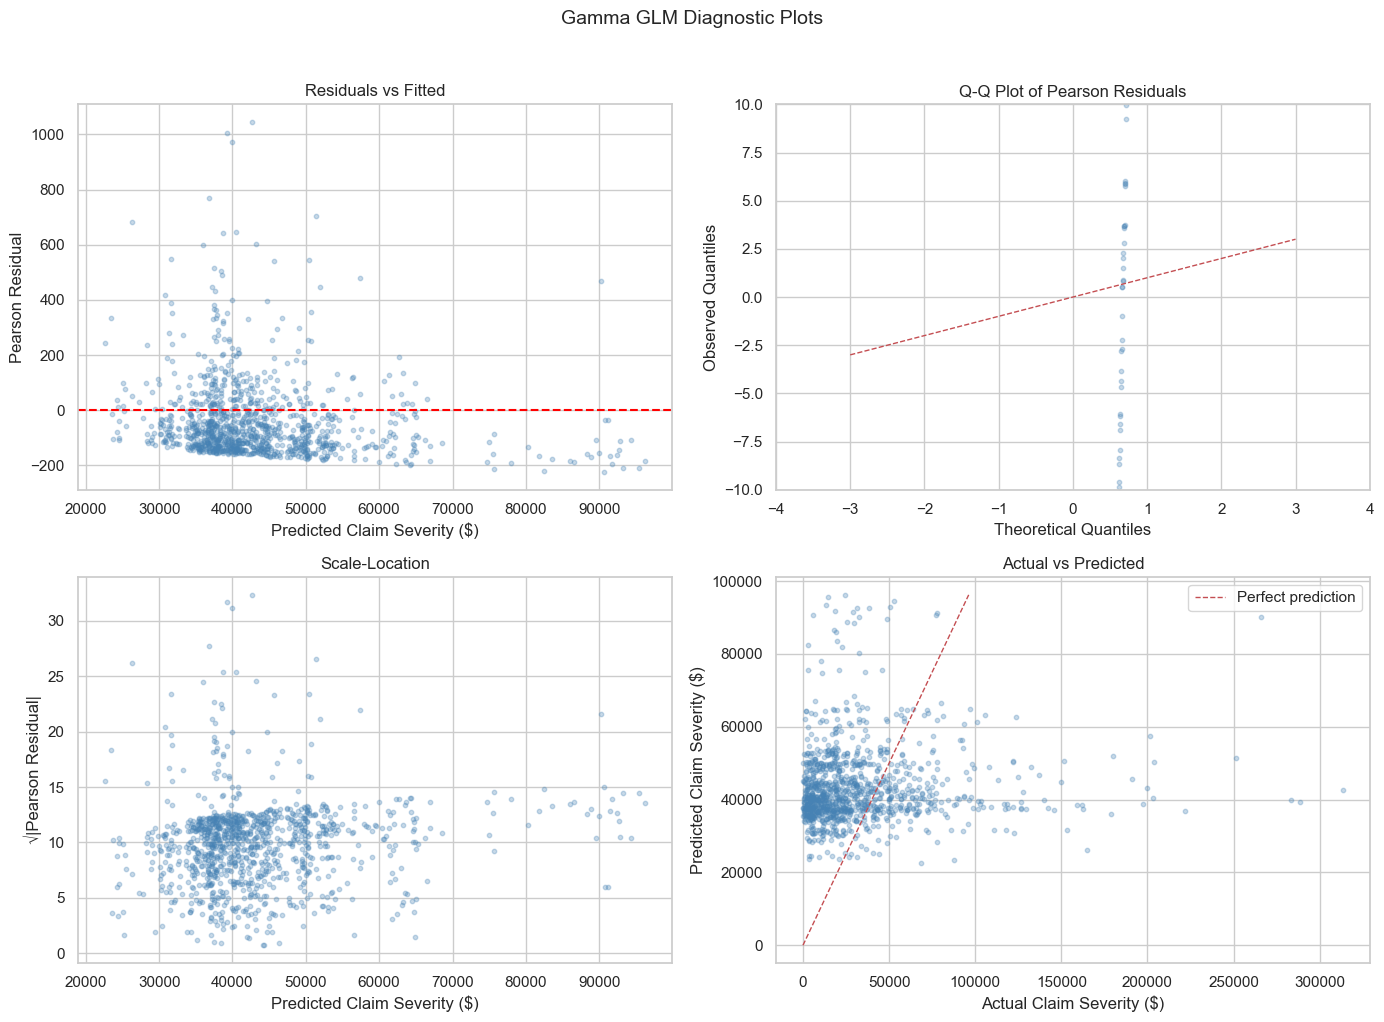

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Fitted
axes[0, 0].scatter(gamma_diag["y_predicted"], gamma_diag["pearson_residual"], alpha=0.3, s=10, c="steelblue")
axes[0, 0].axhline(y=0, color="red", linestyle="--")
axes[0, 0].set_xlabel("Predicted Claim Severity ($)")
axes[0, 0].set_ylabel("Pearson Residual")
axes[0, 0].set_title("Residuals vs Fitted")

# 2. QQ Plot of residuals
from scipy import stats
sorted_resid = np.sort(gamma_diag["pearson_residual"].dropna())
theoretical = stats.norm.ppf(np.linspace(0.001, 0.999, len(sorted_resid)))
axes[0, 1].scatter(theoretical, sorted_resid, alpha=0.3, s=10, c="steelblue")
axes[0, 1].plot([-3, 3], [-3, 3], "r--", linewidth=1)
axes[0, 1].set_xlabel("Theoretical Quantiles")
axes[0, 1].set_ylabel("Observed Quantiles")
axes[0, 1].set_title("Q-Q Plot of Pearson Residuals")
axes[0, 1].set_xlim(-4, 4)
axes[0, 1].set_ylim(-10, 10)

# 3. Scale-Location plot
axes[1, 0].scatter(
    gamma_diag["y_predicted"],
    np.sqrt(np.abs(gamma_diag["pearson_residual"])),
    alpha=0.3, s=10, c="steelblue",
)
axes[1, 0].set_xlabel("Predicted Claim Severity ($)")
axes[1, 0].set_ylabel("√|Pearson Residual|")
axes[1, 0].set_title("Scale-Location")

# 4. Actual vs Predicted
axes[1, 1].scatter(gamma_diag["y_actual"], gamma_diag["y_predicted"], alpha=0.3, s=10, c="steelblue")
max_val = min(gamma_diag["y_actual"].max(), gamma_diag["y_predicted"].max())
axes[1, 1].plot([0, max_val], [0, max_val], "r--", linewidth=1, label="Perfect prediction")
axes[1, 1].set_xlabel("Actual Claim Severity ($)")
axes[1, 1].set_ylabel("Predicted Claim Severity ($)")
axes[1, 1].set_title("Actual vs Predicted")
axes[1, 1].legend()

plt.suptitle("Gamma GLM Diagnostic Plots", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "gamma_diagnostics.png", bbox_inches="tight", dpi=150)
plt.show()

## 10. Geographic Distribution: Claim Severity by County

In [11]:
# Average claim severity by county (all years)
county_severity = (
    panel[panel["avg_claim_severity"] > 0]
    .groupby("county_fips")
    .agg(
        mean_severity=("avg_claim_severity", "mean"),
        total_claims=("claim_count", "sum"),
        years_with_claims=("avg_claim_severity", "count"),
    )
    .reset_index()
)

fig = px.choropleth(
    county_severity,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations="county_fips",
    color="mean_severity",
    color_continuous_scale="YlOrRd",
    scope="usa",
    title="Average NFIP Claim Severity by County (2004-2024)",
    labels={"mean_severity": "Avg Claim ($)"},
    range_color=[0, county_severity["mean_severity"].quantile(0.95)],
)
fig.update_layout(margin={"r": 0, "t": 40, "l": 0, "b": 0}, width=1000, height=600)
fig.show()

## 11. Top 20 Highest-Risk Counties

In [12]:
# Counties with highest average claim severity and frequent disasters
risk_counties = (
    panel[panel["avg_claim_severity"] > 0]
    .groupby(["county_fips", "state"])
    .agg(
        mean_severity=("avg_claim_severity", "mean"),
        total_disasters=("total_disasters", "sum"),
        total_claims=("claim_count", "sum"),
        years_with_claims=("claim_count", "count"),
        cum_disasters=("cum_disasters_3yr", "max"),
    )
    .reset_index()
)

# Require at least 3 years of claims data
risk_counties = risk_counties[risk_counties["years_with_claims"] >= 3]

# Composite risk score
risk_counties["risk_score"] = (
    risk_counties["mean_severity"].rank(pct=True) * 0.4 +
    risk_counties["total_disasters"].rank(pct=True) * 0.3 +
    risk_counties["total_claims"].rank(pct=True) * 0.3
)

top_risk = risk_counties.nlargest(20, "risk_score")

print("Top 20 Highest-Risk Counties (by composite risk score)")
print("="*80)
display(
    top_risk[["county_fips", "state", "mean_severity", "total_disasters", 
              "total_claims", "years_with_claims", "risk_score"]]
    .round(0)
    .reset_index(drop=True)
)

Top 20 Highest-Risk Counties (by composite risk score)


,county_fips,state,mean_severity,total_disasters,total_claims,years_with_claims,risk_score
0,22075,LA,57284.0,34,5180.0,11,1.0
1,48361,TX,39016.0,20,11095.0,11,1.0
2,22019,LA,34440.0,30,7251.0,9,1.0
3,22023,LA,38938.0,23,3086.0,7,1.0
4,48201,TX,33891.0,24,90435.0,12,1.0
5,48339,TX,38755.0,20,6719.0,10,1.0
6,12045,FL,38763.0,25,1170.0,10,1.0
7,12017,FL,34375.0,23,4134.0,11,1.0
8,22103,LA,29258.0,31,26744.0,10,1.0
9,48199,TX,37434.0,21,1373.0,10,1.0


## 12. Claim Severity Trends Over Time

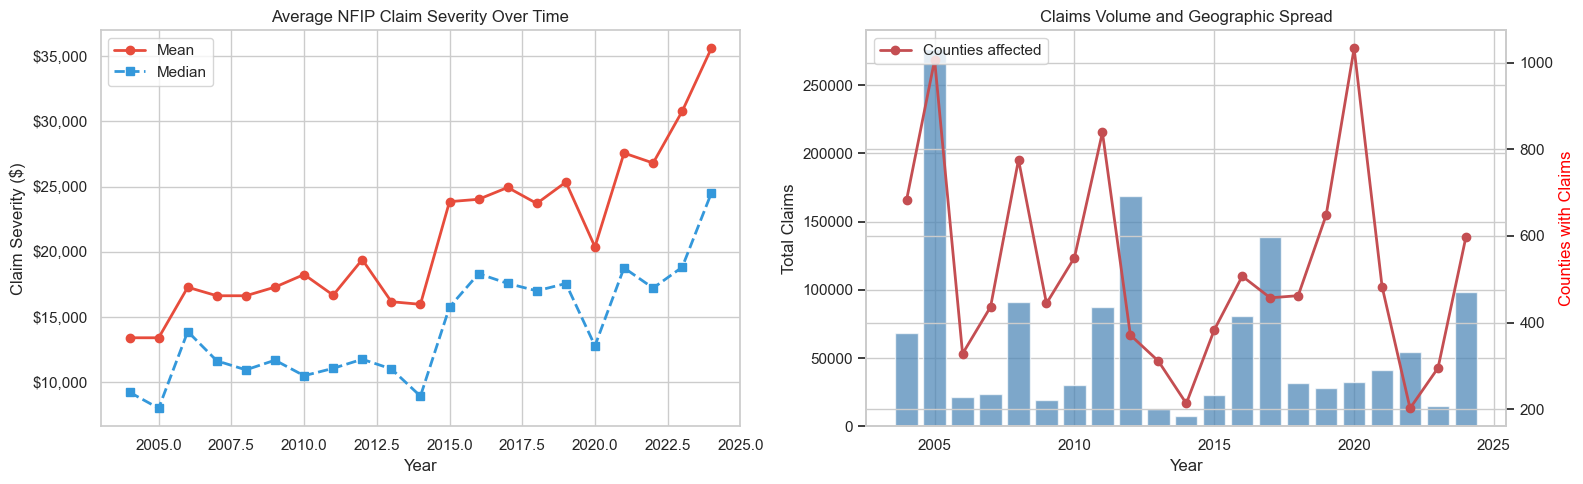

In [13]:
# National average claim severity by year
annual_severity = (
    panel[panel["avg_claim_severity"] > 0]
    .groupby("year")
    .agg(
        mean_severity=("avg_claim_severity", "mean"),
        median_severity=("avg_claim_severity", "median"),
        total_claims=("claim_count", "sum"),
        counties_with_claims=("county_fips", "nunique"),
    )
    .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Severity trend
axes[0].plot(annual_severity["year"], annual_severity["mean_severity"], 
             "o-", color="#e74c3c", label="Mean", linewidth=2)
axes[0].plot(annual_severity["year"], annual_severity["median_severity"], 
             "s--", color="#3498db", label="Median", linewidth=2)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Claim Severity ($)")
axes[0].set_title("Average NFIP Claim Severity Over Time")
axes[0].legend()
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Claims volume trend
axes[1].bar(annual_severity["year"], annual_severity["total_claims"], 
            color="steelblue", alpha=0.7)
ax2 = axes[1].twinx()
ax2.plot(annual_severity["year"], annual_severity["counties_with_claims"], 
         "ro-", linewidth=2, label="Counties affected")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Total Claims")
ax2.set_ylabel("Counties with Claims", color="red")
axes[1].set_title("Claims Volume and Geographic Spread")
ax2.legend(loc="upper left")

plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "severity_trends.png", bbox_inches="tight", dpi=150)
plt.show()

## 13. Key Findings Summary

### Gamma GLM (Claim Severity Drivers)
- **Floods** increase claim severity by **28.6%** per additional flood event (p < 0.001)
- **Severe storms** increase claims by **21.0%** per event (p < 0.001)
- **Hurricanes** increase claims by **12.1%** per event (p < 0.001)
- **Inflation (CPI)** has the largest economic effect: a 1-unit increase in scaled CPI **doubles** expected claims (+125.7%)
- **FEMA Region 6** (TX, LA, NM, OK, AR) has the highest claim severity — **153.8%** above baseline
- **FEMA Region 9** (CA, AZ, HI, NV) is second highest — **151.4%** above baseline
- 15 of 24 features are statistically significant (p < 0.05)

### Logistic Regression (Claims Surge Prediction)
- **AUC-ROC: 0.687** (test set), **5-Fold CV AUC: 0.728** — meaningful discrimination above random
- **Severe storms** (OR=1.64), **floods** (OR=1.59), and **hurricanes** (OR=1.51) are the strongest surge predictors
- **Prior claim count** (OR=0.08) strongly predicts *against* surge — regression to the mean effect
- **Mortgage rates** (OR=1.45) and **inflation** (OR=1.48) increase surge odds — economic stress compounds disaster risk

### Implications for Module 3 (Uninsurability Classification)
- Counties in FEMA Regions 6 and 9 are most at risk of becoming uninsurable
- The combination of accelerating disaster frequency (Module 1) and increasing claim severity (Module 2) creates a compounding risk
- Macroeconomic conditions (inflation, rates) amplify climate-driven insurance stress
- The claim severity trend is accelerating — 2022-2024 test data shows significantly higher severity than the model predicts based on 2004-2021 training data